In [48]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
#import dataset
df = pd.read_csv("spam.csv", encoding="latin-1")

In [32]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df['spam_label'] = df['label'].map({'ham': 0,'spam': 1})

In [33]:
df.head()

,label,text,spam_label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [34]:
#splitting data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['spam_label'], test_size=0.2, random_state=41)

In [37]:
#text tokenization
vocab_size = 1000
max_length = 50
oov_tok = '<OOV>'
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, lower=True, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
# word_index

In [39]:
#add paddings for the model
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

train_pad = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_pad = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [44]:
#building model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
#compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

#add callbacks
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,577
Trainable params: 16,577
Non-trainable params: 0
__________________________________________________

In [47]:
#fit the model
history = model.fit(
    train_pad,
    y_train,
    validation_data=(test_pad, y_test),
    epochs=25,
    callbacks=[callback],
    verbose=1
)

Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-06-21 17:48:01.832206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 3s 20ms/step - loss: 0.4897 - accuracy: 0.8647 - val_loss: 0.3427 - val_accuracy: 0.8592
Epoch 2/25
  1/140 [..............................] - ETA: 1s - loss: 0.4169 - accuracy: 0.8125

2022-06-21 17:48:04.593780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 2s 12ms/step - loss: 0.2937 - accuracy: 0.8687 - val_loss: 0.2302 - val_accuracy: 0.8807
Epoch 3/25
140/140 [==============================] - 2s 12ms/step - loss: 0.1678 - accuracy: 0.9419 - val_loss: 0.1374 - val_accuracy: 0.9578
Epoch 4/25
140/140 [==============================] - 2s 11ms/step - loss: 0.0996 - accuracy: 0.9731 - val_loss: 0.0956 - val_accuracy: 0.9695
Epoch 5/25
140/140 [==============================] - 2s 11ms/step - loss: 0.0747 - accuracy: 0.9782 - val_loss: 0.0795 - val_accuracy: 0.9695
Epoch 6/25
140/140 [==============================] - 2s 11ms/step - loss: 0.0562 - accuracy: 0.9847 - val_loss: 0.0725 - val_accuracy: 0.9731
Epoch 7/25
140/140 [==============================] - 2s 11ms/step - loss: 0.0498 - accuracy: 0.9861 - val_loss: 0.0638 - val_accuracy: 0.9767
Epoch 8/25
140/140 [==============================] - 2s 11ms/step - loss: 0.0421 - accuracy: 0.9890 - val_loss: 0.0604 - val_accuracy: 0.9785
Epoch 9/25

In [60]:
#evaluate the result
result = model.evaluate(test_pad, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Loss:   {loss*100:.2f}%")
print(f"[+] Accuracy: {accuracy*100:.2f}%")

35/35 [==============================] - 0s 5ms/step - loss: 0.0583 - accuracy: 0.9848
[+] Loss:   5.83%
[+] Accuracy: 98.48%


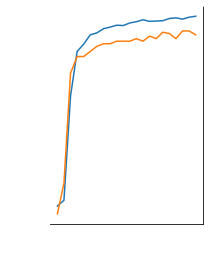

In [61]:
#visualize the model performance by epoch
fig = plt.figure()

ax = fig.add_subplot(121)

ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.show()

In [62]:
#spam prediction function
def predict(text):
    seq = tokenizer.texts_to_sequences(text)
    pad = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return model.predict(pad)

In [67]:
#examples
sample_text = [
    'Greg, can you call me back once you get this?', 
    'Congrats on your new iPhone! Click here to claim your prize...', 
    'Really like that new photo of you', 
    'Did you hear the news today? Terrible what has happened...', 
    'Attend this free COVID webinar and get testing kit today: Book your session now...'
]

predict(sample_text)

1/1 [==============================] - 0s 30ms/step


array([[0.0014421 ],
       [0.98656625],
       [0.00171175],
       [0.0017951 ],
       [0.77516675]], dtype=float32)